This is the original model

# Load data

In [1]:
import os
import argparse
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
from keras.models import Sequential, Model
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.layers import Input
from keras.utils.data_utils import get_file
#from keras.regularizers import WeightRegularizer
from keras.optimizers import Nadam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, History
from keras.layers.normalization import BatchNormalization
#from theano.ifelse import ifelse

Using Theano backend.


In [3]:
#name = 'bpi_12_w'
name = 'helpdesk'
args = {
    'inputdir': '../input/{}/'.format(name),   
    'outputdir': './output_files/{}/'.format(name)
}

args = argparse.Namespace(**args)

In [4]:
if not os.path.isdir(args.outputdir):
    os.makedirs(args.outputdir)

In [5]:
with open(args.inputdir + 'parameters_newfeatures.pkl', "rb") as f:
    maxlen = pickle.load(f)
    num_features = pickle.load(f)
    chartoindice = pickle.load(f)
    targetchartoindice = pickle.load(f)
    divisor = pickle.load(f)
    divisor2 = pickle.load(f)

In [6]:
with open(args.inputdir + 'preprocessed_data_newfeatures.pkl', "rb") as f:
    X = pickle.load(f)
    y_a = pickle.load(f)
    y_t = pickle.load(f)
    X_test = pickle.load(f)
    y_a_test = pickle.load(f)
    y_t_test = pickle.load(f)

In [7]:
X.shape

(9167, 15, 26)

In [8]:
y_a.shape

(9167, 10)

# Model

In [15]:
# build the model: 
print('Build model...')
main_input = Input(shape=(maxlen, num_features), name='main_input')

# train a 2-layer LSTM with one shared layer
l1 = LSTM(100, kernel_initializer="glorot_uniform", dropout=0.2, return_sequences=True, implementation=2)(main_input) # the shared layer
b1 = BatchNormalization()(l1)

l2_1 = LSTM(100, kernel_initializer="glorot_uniform", dropout=0.2, return_sequences=False, implementation=2)(b1) # the layer specialized in activity prediction
b2_1 = BatchNormalization()(l2_1)
l2_2 = LSTM(100, kernel_initializer="glorot_uniform", dropout=0.2, return_sequences=False, implementation=2)(b1) # the layer specialized in time prediction
b2_2 = BatchNormalization()(l2_2)

act_output = Dense(len(targetchartoindice), kernel_initializer="glorot_uniform", name="act_output", activation="softmax")(b2_1)
time_output = Dense(1, kernel_initializer="glorot_uniform", name="time_output")(b2_2)

model = Model(inputs=[main_input], outputs=[act_output, time_output])

opt = Nadam(lr=0.005, beta_1=1, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004, clipvalue=3)

model.compile(loss={'act_output':'categorical_crossentropy', 'time_output':'mae'}, optimizer=opt)
early_stopping = EarlyStopping(monitor='val_loss', patience=100)
model_checkpoint = ModelCheckpoint(args.outputdir + 'model_{epoch:02d}-{val_loss:.2f}.h5', 
                                   monitor='val_loss', verbose=0, save_best_only=True, 
                                   save_weights_only=False, mode='auto')
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=0, 
                               mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
history = History()

model.fit(X, {'act_output':y_a, 'time_output':y_t}, validation_split=0.2, verbose=2, 
          callbacks=[early_stopping, model_checkpoint, lr_reducer, history], batch_size=maxlen, epochs=500)

Build model...
Train on 7333 samples, validate on 1834 samples
Epoch 1/500
18s - loss: 2.5050 - act_output_loss: 1.2716 - time_output_loss: 1.2334 - val_loss: 2.1102 - val_act_output_loss: 1.0177 - val_time_output_loss: 1.0925
Epoch 2/500
20s - loss: 2.0837 - act_output_loss: 1.0184 - time_output_loss: 1.0654 - val_loss: 2.0074 - val_act_output_loss: 0.9722 - val_time_output_loss: 1.0352
Epoch 3/500
19s - loss: 2.0494 - act_output_loss: 1.0016 - time_output_loss: 1.0479 - val_loss: 2.0895 - val_act_output_loss: 1.0551 - val_time_output_loss: 1.0345
Epoch 4/500
18s - loss: 2.0087 - act_output_loss: 0.9694 - time_output_loss: 1.0393 - val_loss: 1.9941 - val_act_output_loss: 0.9609 - val_time_output_loss: 1.0332
Epoch 5/500
19s - loss: 1.9865 - act_output_loss: 0.9540 - time_output_loss: 1.0325 - val_loss: 2.0692 - val_act_output_loss: 1.0403 - val_time_output_loss: 1.0289
Epoch 6/500
18s - loss: 1.9902 - act_output_loss: 0.9601 - time_output_loss: 1.0301 - val_loss: 1.9840 - val_act_outp

In [10]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
main_input (InputLayer)          (None, 15, 26)        0                                            
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (None, 15, 100)       50800       main_input[0][0]                 
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 15, 100)       400         lstm_1[0][0]                     
____________________________________________________________________________________________________
lstm_2 (LSTM)                    (None, 100)           80400       batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [11]:
history.history.keys()

dict_keys(['time_output_loss', 'act_output_loss', 'val_loss', 'lr', 'val_time_output_loss', 'val_act_output_loss', 'loss'])

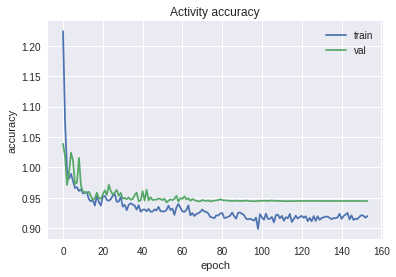

In [12]:
# summarize history for activity accuracy
plt.plot(history.history['act_output_loss'])
plt.plot(history.history['val_act_output_loss'])
plt.title('Activity accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

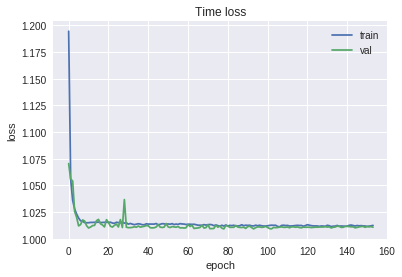

In [13]:
# summarize history for time loss
plt.plot(history.history['time_output_loss'])
plt.plot(history.history['val_time_output_loss'])
plt.title('Time loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

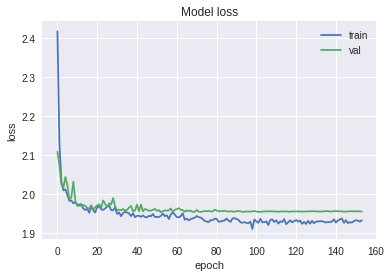

In [14]:
# summarize history for model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# Model keras 1

``` python
# build the model: 
print('Build model...')
main_input = Input(shape=(maxlen, num_features), name='main_input')

# train a 2-layer LSTM with one shared layer
l1 = LSTM(100, consume_less='gpu', init='glorot_uniform', return_sequences=True, dropout_W=0.2)(main_input) # the shared layer
b1 = BatchNormalization()(l1)

l2_1 = LSTM(100, consume_less='gpu', init='glorot_uniform', return_sequences=False, dropout_W=0.2)(b1) # the layer specialized in activity prediction
b2_1 = BatchNormalization()(l2_1)
l2_2 = LSTM(100, consume_less='gpu', init='glorot_uniform', return_sequences=False, dropout_W=0.2)(b1) # the layer specialized in time prediction
b2_2 = BatchNormalization()(l2_2)

act_output = Dense(len(targetchartoindice), activation='softmax', init='glorot_uniform', name='act_output')(b2_1)
time_output = Dense(1, init='glorot_uniform', name='time_output')(b2_2)

model = Model(input=[main_input], output=[act_output, time_output])

opt = Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004, clipvalue=3)

model.compile(loss={'act_output':'categorical_crossentropy', 'time_output':'mae'}, optimizer=opt)
early_stopping = EarlyStopping(monitor='val_loss', patience=42)
model_checkpoint = ModelCheckpoint(args.outputdir + 'model_{epoch:02d}-{val_loss:.2f}.h5', 
                                   monitor='val_loss', verbose=0, save_best_only=True, 
                                   save_weights_only=False, mode='auto')
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=0, 
                               mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)

model.fit(X, {'act_output':y_a, 'time_output':y_t}, validation_split=0.2, verbose=2, 
          callbacks=[early_stopping, model_checkpoint, lr_reducer], batch_size=maxlen, nb_epoch=500)
```